In [157]:
import requests
import pyupbit
import pprint
from common_Import import *
from utils.Generate_plot_and_indicators import *
from utils.trend_combination import trend_combinations

#### 원본 데이터 로드

In [158]:
target_ticker = 'KRW-SOL'

In [159]:
target_ticker_df_10 = pyupbit.get_ohlcv(target_ticker, "minute10", count=6 * 24 * 365)

In [160]:
target_ticker_df_10 = target_ticker_df_10.iloc[:, 0:6]

In [161]:
target_ticker_df_10

,open,high,low,close,volume,value
2023-08-14 16:30:00,32600.0,32640.0,32590.0,32630.0,1589.879818,5.184718e+07
2023-08-14 16:40:00,32620.0,32630.0,32540.0,32540.0,1378.435767,4.490549e+07
2023-08-14 16:50:00,32530.0,32560.0,32510.0,32530.0,430.923969,1.401899e+07
2023-08-14 17:00:00,32530.0,32600.0,32530.0,32600.0,454.606400,1.480234e+07
2023-08-14 17:10:00,32640.0,32660.0,32600.0,32650.0,793.431355,2.590291e+07
...,...,...,...,...,...,...
2024-08-14 10:40:00,202300.0,202950.0,201850.0,201850.0,8804.320459,1.780997e+09
2024-08-14 10:50:00,201850.0,202150.0,201250.0,201300.0,7165.875057,1.444638e+09
2024-08-14 11:00:00,201350.0,202300.0,201050.0,202050.0,5374.557658,1.083979e+09
2024-08-14 11:10:00,202050.0,202300.0,201800.0,202100.0,4586.005415,9.265839e+08


In [162]:
# Move the index to a new column called 'time'
target_ticker_df_10['time'] = target_ticker_df_10.index

# Reset the index to be numeric
target_ticker_df_10.reset_index(drop=True, inplace=True)

In [163]:
target_ticker_df_10 = target_ticker_df_10[['time'] + [col for col in target_ticker_df_10.columns if col != 'time']]

In [164]:
target_ticker_df_10.to_csv("origin.csv")

#### 추세 라벨링 추가

In [222]:
stock_data = pd.read_csv("./origin.csv", index_col=0)

In [223]:
# analyze_trend 함수 정의 (주어진 대로 사용)
def analyze_trend(data):
    if data.empty:
        return None
    
    pricing = data['close']
    x = np.arange(len(pricing))
    y = pricing.values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    
    mean_close = pricing.mean()
    std_close = pricing.std()
    
    upper_bound = mean_close + std_close * 0.43 
    lower_bound = mean_close - std_close * 0.43
    trend_point = z[0] * x[-1] + z[1]
    
    if trend_point > upper_bound:
        trend = 'up'
    elif lower_bound < trend_point < upper_bound:
        trend = 'sideway'
    else:
        trend = 'down'
    
    return trend

In [224]:
# 데이터프레임에 새로운 컬럼 추가
def add_trend_column(df, window_len):
    trends = []
    end_date = pd.Timestamp('2024-08-15').date()
    
    # 'time' 컬럼을 datetime 형식으로 변환
    df['time'] = pd.to_datetime(df['time'])
    
    for i in tqdm(range(len(df))):
        # 마지막 날짜 이후 데이터는 계산하지 않음
        if df.iloc[i]['time'].date() >= end_date:
            trends.append(None)
            continue

        if i >= window_len-1:
            subset = df.iloc[i-window_len+1:i+1]
            trend = analyze_trend(subset)
            trends.append(trend)
        else:
            trends.append(None)
        
    df[f'trend_{window_len}'] = trends
    return df

In [225]:
window_lens = [6 * 24, 6 * 24 * 3, 6 * 24 * 5]

In [226]:
# 새로운 컬럼을 추가한 데이터프레임 생성
for window_len in window_lens:
    df_with_trend = add_trend_column(stock_data, window_len)

100%|██████████| 52560/52560 [00:38<00:00, 1356.74it/s]


In [227]:
df_with_trend

,time,open,high,low,close,volume,value,trend_144,trend_432,trend_720
0,2023-08-14 16:30:00,32600.0,32640.0,32590.0,32630.0,1589.879818,5.184718e+07,None,None,None
1,2023-08-14 16:40:00,32620.0,32630.0,32540.0,32540.0,1378.435767,4.490549e+07,None,None,None
2,2023-08-14 16:50:00,32530.0,32560.0,32510.0,32530.0,430.923969,1.401899e+07,None,None,None
3,2023-08-14 17:00:00,32530.0,32600.0,32530.0,32600.0,454.606400,1.480234e+07,None,None,None
4,2023-08-14 17:10:00,32640.0,32660.0,32600.0,32650.0,793.431355,2.590291e+07,None,None,None
...,...,...,...,...,...,...,...,...,...,...
52555,2024-08-14 10:40:00,202300.0,202950.0,201850.0,201850.0,8804.320459,1.780997e+09,up,down,down
52556,2024-08-14 10:50:00,201850.0,202150.0,201250.0,201300.0,7165.875057,1.444638e+09,up,down,down
52557,2024-08-14 11:00:00,201350.0,202300.0,201050.0,202050.0,5374.557658,1.083979e+09,up,down,down
52558,2024-08-14 11:10:00,202050.0,202300.0,201800.0,202100.0,4586.005415,9.265839e+08,up,down,down


In [228]:
df_with_trend.to_csv("trend.csv")

#### 데이터 정리

In [284]:
df_with_trend = pd.read_csv('./trend.csv', index_col=0)

In [257]:
# 조합에 따른 최종 추세 라벨 추가
def determine_final_trend(row):
    if pd.isnull(row['trend_144']) or pd.isnull(row['trend_432']) or pd.isnull(row['trend_720']):
        return None
    return trend_combinations.get((row['trend_144'], row['trend_432'], row['trend_720']), None)

df_with_trend['Final_Trend'] = df_with_trend.apply(determine_final_trend, axis=1)

In [258]:
df_TA = generate_technical_analysis_indicators(df_with_trend)

In [259]:
df_TA

,time,open,high,low,close,volume,value,trend_144,trend_432,trend_720,Final_Trend,BBAND_UPPER,BBAND_MIDDLE,BBAND_lOWER,MOM,RSI
0,2023-08-14 16:30:00,32600.0,32640.0,32590.0,32630.0,1589.879818,5.184718e+07,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
1,2023-08-14 16:40:00,32620.0,32630.0,32540.0,32540.0,1378.435767,4.490549e+07,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
2,2023-08-14 16:50:00,32530.0,32560.0,32510.0,32530.0,430.923969,1.401899e+07,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
3,2023-08-14 17:00:00,32530.0,32600.0,32530.0,32600.0,454.606400,1.480234e+07,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
4,2023-08-14 17:10:00,32640.0,32660.0,32600.0,32650.0,793.431355,2.590291e+07,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,2024-08-14 10:40:00,202300.0,202950.0,201850.0,201850.0,8804.320459,1.780997e+09,up,down,down,down,206823.112862,204232.5,201641.887138,-3000.0,33.242924
52556,2024-08-14 10:50:00,201850.0,202150.0,201250.0,201300.0,7165.875057,1.444638e+09,up,down,down,down,206846.790212,204025.0,201203.209788,-3700.0,30.624878
52557,2024-08-14 11:00:00,201350.0,202300.0,201050.0,202050.0,5374.557658,1.083979e+09,up,down,down,down,206697.144715,203847.5,200997.855285,-2450.0,37.816642
52558,2024-08-14 11:10:00,202050.0,202300.0,201800.0,202100.0,4586.005415,9.265839e+08,up,down,down,down,206544.038300,203685.0,200825.961700,-2400.0,38.276029


In [260]:
# MOM의 추세를 분석하는 함수 정의
def analyze_mom_trend(mom_values):
    if mom_values.empty:
        return None
    
    mean_mom = mom_values.mean()
    ''' std_mom = mom_values.std()
    
    upper_bound = mean_mom + std_mom * 0.43
    lower_bound = mean_mom - std_mom * 0.43 '''
    last_mom_value = mom_values.iloc[-1]
    
    if last_mom_value > mean_mom:
        trend = 'up'
    else:
        trend = 'down'
    
    return trend

# 데이터프레임에 새로운 MOM 트렌드 컬럼 추가
def add_mom_trend_column(df, window_len):
    mom_trends = []
    end_date = pd.Timestamp('2024-08-15').date()
    
    for i in tqdm(range(len(df))):
        # 마지막 날짜 이후 데이터는 계산하지 않음
        if df.iloc[i]['time'].date() >= end_date:
            mom_trends.append(None)
            continue

        if i >= window_len-1:
            subset_mom = df.iloc[i-window_len-1:i+1]['MOM']
            mom_trend = analyze_mom_trend(subset_mom)
            mom_trends.append(mom_trend)
        else:
            mom_trends.append(None)
        
    df[f'mom_trend'] = mom_trends
    return df

df_TA['time'] = pd.to_datetime(df_TA['time'])
window_len = 6 * 24 * 5
df_TA = add_mom_trend_column(df_TA, window_len)

100%|██████████| 52560/52560 [00:16<00:00, 3121.09it/s]


In [261]:
df_TA['EMA_10'] = df_TA['close'].ewm(span=10, adjust=False).mean()
df_TA['EMA_20'] = df_TA['close'].ewm(span=20, adjust=False).mean()
df_TA['EMA_50'] = df_TA['close'].ewm(span=50, adjust=False).mean()

In [262]:
df_TA['change_per'] = df_TA['close'].pct_change(periods=6) * 100

In [263]:
# Remove rows with None values and reset index
df_TA = df_TA.dropna().reset_index(drop=True)

In [264]:
df_TA.to_csv("TA.csv")

#### 거래신호 생성

In [276]:
df_TA = pd.read_csv('./TA.csv', index_col=0)

In [277]:
# 거래 상태 초기화
current_action = 'No action'
initial_seed_ratio = 0.0
current_profit = 0.0
buy_price = 0.0
holding_period = 0
no_action_period = 0

# 손절 및 익절 기준 변수 설정
stop_loss_threshold = -3.0  # 손절 기준
take_profit_threshold_sideway = 3.0  # 횡보장에서의 익절 기준
take_profit_threshold_uptrend = 4.5  # 상승장에서의 익절 기준

In [278]:
import pandas as pd

# 결과 컬럼을 추가할 리스트 초기화
profit_ratio_list = []
seed_ratio_list = []
action_list = []
reason_list = []

# 데이터프레임 순회
for index, row in df_TA.iterrows():
    close = row['close']
    bband_lower = row['BBAND_lOWER']
    bband_upper = row['BBAND_UPPER']
    rsi = row['RSI']
    mom = row['MOM']
    final_trend = row['Final_Trend']
    ema_10 = row['EMA_10']
    ema_20 = row['EMA_20']
    ema_50 = row['EMA_50']

    if current_action == 'No action':
        if final_trend == 'down':
            action_list.append('No action')
            profit_ratio_list.append(0.0)
            seed_ratio_list.append(0.0)
            reason_list.append('Final trend is down, no action taken')
        
        elif final_trend == 'sideway':
            if close <= bband_lower and rsi < 40:
                current_action = 'Buy'
                buy_price = close
                initial_seed_ratio = 0.5
                action_list.append('Buy')
                profit_ratio_list.append(0.0)
                seed_ratio_list.append(initial_seed_ratio)
                reason_list.append(f'Final trend is sideway, RSI < 40, close is at or below BBAND lower (close: {close}, BBAND lower: {bband_lower})')
            else:
                action_list.append('No action')
                profit_ratio_list.append(0.0)
                seed_ratio_list.append(0.0)
                reason_list.append(f'Final trend is sideway, but RSI >= 40 or close is not at BBAND lower (RSI: {rsi}, close: {close}, BBAND lower: {bband_lower})')

        elif final_trend == 'up':
            if rsi < 50 and ema_10 < ema_20:
                current_action = 'Buy'
                buy_price = close
                initial_seed_ratio = 0.5
                action_list.append('Buy')
                profit_ratio_list.append(0.0)
                seed_ratio_list.append(initial_seed_ratio)
                reason_list.append(f'Final trend is up, RSI < 50, EMA_10 < EMA_20 (RSI: {rsi}, EMA_10: {ema_10}, EMA_20: {ema_20})')
            else:
                action_list.append('No action')
                profit_ratio_list.append(0.0)
                seed_ratio_list.append(0.0)
                reason_list.append(f'Final trend is up, but RSI >= 50 or EMA_10 >= EMA_20 (RSI: {rsi}, EMA_10: {ema_10}, EMA_20: {ema_20})')

    elif current_action == 'Buy':
        holding_period += 1
        current_profit = (close - buy_price) / buy_price * 100
        
        if final_trend == 'down':
            action_list.append('Sell')
            profit_ratio_list.append(current_profit)
            seed_ratio_list.append(0.0)
            reason_list.append(f'Final trend changed to down, sell executed with profit: {current_profit:.2f}%')
            current_action = 'No action'
            initial_seed_ratio = 0.0
            holding_period = 0
        
        elif final_trend == 'sideway':
            if close >= bband_upper and current_profit >= take_profit_threshold_sideway:
                action_list.append('Sell')
                profit_ratio_list.append(current_profit)
                seed_ratio_list.append(0.0)
                reason_list.append(f'Final trend is sideway, close is at or above BBAND upper (close: {close}, BBAND upper: {bband_upper}) and profit >= {take_profit_threshold_sideway}%, sell executed')
                current_action = 'No action'
                initial_seed_ratio = 0.0
                holding_period = 0
            else:
                action_list.append('Holding')
                profit_ratio_list.append(current_profit)
                seed_ratio_list.append(initial_seed_ratio)
                reason_list.append(f'Holding in sideway market, current profit: {current_profit:.2f}%')

                if initial_seed_ratio < 1.0 and current_profit <= stop_loss_threshold and close <= bband_lower:
                    initial_seed_ratio = 1.0
                    buy_price = (buy_price + close) / 2
                    action_list[-1] = 'Buy more'
                    reason_list[-1] = f'Additional buy due to profit <= {stop_loss_threshold}%, new buy price: {buy_price:.2f}'

        elif final_trend == 'up':
            if mom <= 0 and current_profit >= take_profit_threshold_uptrend:
                action_list.append('Sell')
                profit_ratio_list.append(current_profit)
                seed_ratio_list.append(0.0)
                reason_list.append(f'Final trend is up, MOM <= 0 and profit >= {take_profit_threshold_uptrend}%, sell executed')
                current_action = 'No action'
                initial_seed_ratio = 0.0
                holding_period = 0
            else:
                action_list.append('Holding')
                profit_ratio_list.append(current_profit)
                seed_ratio_list.append(initial_seed_ratio)
                reason_list.append(f'Holding in uptrend, current profit: {current_profit:.2f}%')

                if initial_seed_ratio < 1.0 and current_profit <= stop_loss_threshold and (ema_10 < ema_20 < ema_50 or close <= bband_lower):
                    initial_seed_ratio = 1.0
                    buy_price = (buy_price + close) / 2
                    action_list[-1] = 'Buy more'
                    reason_list[-1] = f'Additional buy due to profit <= {stop_loss_threshold}%, new buy price: {buy_price:.2f}'

    elif current_action == 'Holding':
        holding_period += 1
        current_profit = (close - buy_price) / buy_price * 100
        
        if final_trend == 'down':
            action_list.append('Sell')
            profit_ratio_list.append(current_profit)
            seed_ratio_list.append(0.0)
            reason_list.append(f'Final trend changed to down, sell executed with profit: {current_profit:.2f}%')
            current_action = 'No action'
            initial_seed_ratio = 0.0
            holding_period = 0
        
        elif final_trend == 'sideway':
            if close >= bband_upper and current_profit >= take_profit_threshold_sideway:
                action_list.append('Sell')
                profit_ratio_list.append(current_profit)
                seed_ratio_list.append(0.0)
                reason_list.append(f'Final trend is sideway, close is at or above BBAND upper (close: {close}, BBAND upper: {bband_upper}) and profit >= {take_profit_threshold_sideway}%, sell executed')
                current_action = 'No action'
                initial_seed_ratio = 0.0
                holding_period = 0
            else:
                action_list.append('Holding')
                profit_ratio_list.append(current_profit)
                seed_ratio_list.append(initial_seed_ratio)
                reason_list.append(f'Holding in sideway market, current profit: {current_profit:.2f}%')

                if initial_seed_ratio < 1.0 and current_profit <= stop_loss_threshold and close <= bband_lower:
                    initial_seed_ratio = 1.0
                    buy_price = (buy_price + close) / 2
                    action_list[-1] = 'Buy more'
                    reason_list[-1] = f'Additional buy due to profit <= {stop_loss_threshold}%, new buy price: {buy_price:.2f}'

        elif final_trend == 'up':
            if mom <= 0 and current_profit >= take_profit_threshold_uptrend:
                action_list.append('Sell')
                profit_ratio_list.append(current_profit)
                seed_ratio_list.append(0.0)
                reason_list.append(f'Final trend is up, MOM <= 0 and profit >= {take_profit_threshold_uptrend}%, sell executed')
                current_action = 'No action'
                initial_seed_ratio = 0.0
                holding_period = 0
            else:
                action_list.append('Holding')
                profit_ratio_list.append(current_profit)
                seed_ratio_list.append(initial_seed_ratio)
                reason_list.append(f'Holding in uptrend, current profit: {current_profit:.2f}%')
                
                if initial_seed_ratio < 1.0 and current_profit <= stop_loss_threshold and (ema_10 < ema_20 < ema_50 or close <= bband_lower):
                    initial_seed_ratio = 1.0
                    buy_price = (buy_price + close) / 2
                    action_list[-1] = 'Buy more'
                    reason_list[-1] = f'Additional buy due to profit <= {stop_loss_threshold}%, new buy price: {buy_price:.2f}'

    no_action_period += 1 if current_action == 'No action' else 0

# 라벨링 컬럼을 데이터프레임에 추가
df_TA['Profit_Ratio'] = profit_ratio_list
df_TA['Seed_Ratio'] = seed_ratio_list
df_TA['Action'] = action_list
df_TA['Reason'] = reason_list

In [279]:
df_TA.to_csv('trading.csv')

In [280]:
df_filtered = df_TA[['time', 'open', 'high', 'low', 'close', 'volume', 'value', 'Profit_Ratio', 'Seed_Ratio', 'Action', 'Reason']]

In [281]:
# 초기 변수 설정
initial_seed = 4000000  # 400만원
current_seed = 0
average_price = 0
accumulated_profit = 0

# 결과 저장용 리스트
profits = []
cumulative_profits = []

# 데이터프레임 순회
for index, row in df_filtered.iterrows():
    action = row['Action']
    close_price = row['close']
    
    if action == 'Buy':
        current_seed = initial_seed * 0.5
        average_price = close_price
        profits.append(0)
        cumulative_profits.append(accumulated_profit)
    
    elif action == 'Buy more':
        # 현재 시드와 새로운 시드를 합산한 후 평균 가격 업데이트
        new_seed = initial_seed * 0.5
        average_price = (average_price * current_seed + close_price * new_seed) / (current_seed + new_seed)
        current_seed += new_seed
        profits.append(0)
        cumulative_profits.append(accumulated_profit)
    
    elif action == 'Sell':
        if current_seed > 0:
            profit = (close_price - average_price) * (current_seed / average_price)
            accumulated_profit += profit
            profits.append(profit)
            cumulative_profits.append(accumulated_profit)
            current_seed = 0  # 전량 매도
        else:
            profits.append(0)
            cumulative_profits.append(accumulated_profit)
    else:  # No action, Holding 등
        profits.append(0)
        cumulative_profits.append(accumulated_profit)

# 결과를 데이터프레임에 추가
df_filtered['Profit'] = profits
df_filtered['Cumulative Profit'] = cumulative_profits


C:\Users\coden\AppData\Local\Temp\ipykernel_23056\3759703808.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Profit'] = profits
C:\Users\coden\AppData\Local\Temp\ipykernel_23056\3759703808.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Cumulative Profit'] = cumulative_profits


In [282]:
df_filtered.to_csv('meme.csv')

In [283]:
import pandas as pd

# 거래 횟수 계산
no_trade = len(df_filtered[df_filtered['Profit'] > 0]) + len(df_filtered[df_filtered['Profit'] < 0])

# 승률 계산
winning_ratio = len(df_filtered[(df_filtered['Action'] == 'Sell') & (df_filtered['Profit'] > 0)]) / no_trade if no_trade > 0 else 0

# 수익 평균, 손실 평균 계산
profit_average = df_filtered[df_filtered['Profit'] > 0]['Profit'].mean()
loss_average = df_filtered[df_filtered['Profit'] < 0]['Profit'].mean()

# payoff ratio 계산
payoff_ratio = profit_average / -loss_average if loss_average < 0 else 0

# profit factor 계산
profit_factor = -df_filtered[df_filtered['Profit'] > 0]['Profit'].sum() / df_filtered[df_filtered['Profit'] < 0]['Profit'].sum()

# Maximum Drawdown (MDD) 계산
df_filtered = df_filtered[df_filtered['Cumulative Profit'].notna()]  # NaN 값 제거
peak = df_filtered['Cumulative Profit'].expanding().max()
drawdown = df_filtered['Cumulative Profit'] / peak - 1
max_drawdown = drawdown[drawdown != -np.inf].min()

# 최종 수익 계산
last_profit = df_filtered['Cumulative Profit'].iloc[-1]

# 결과 출력
print(f"거래 횟수: {no_trade}")
print(f"승률: {winning_ratio * 100:.2f}%")
print(f"수익 평균: {profit_average:.2f}")
print(f"손실 평균: {loss_average:.2f}")
print(f"Payoff Ratio: {payoff_ratio:.2f}")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Maximum Drawdown (MDD): {max_drawdown:.2f}%")
print(f'최종 수익금액 : {last_profit:.2f}원')

거래 횟수: 204
승률: 59.31%
수익 평균: 89413.38
손실 평균: -79671.65
Payoff Ratio: 1.12
Profit Factor: 1.64
Maximum Drawdown (MDD): -0.29%
최종 수익금액 : 4206271.77원


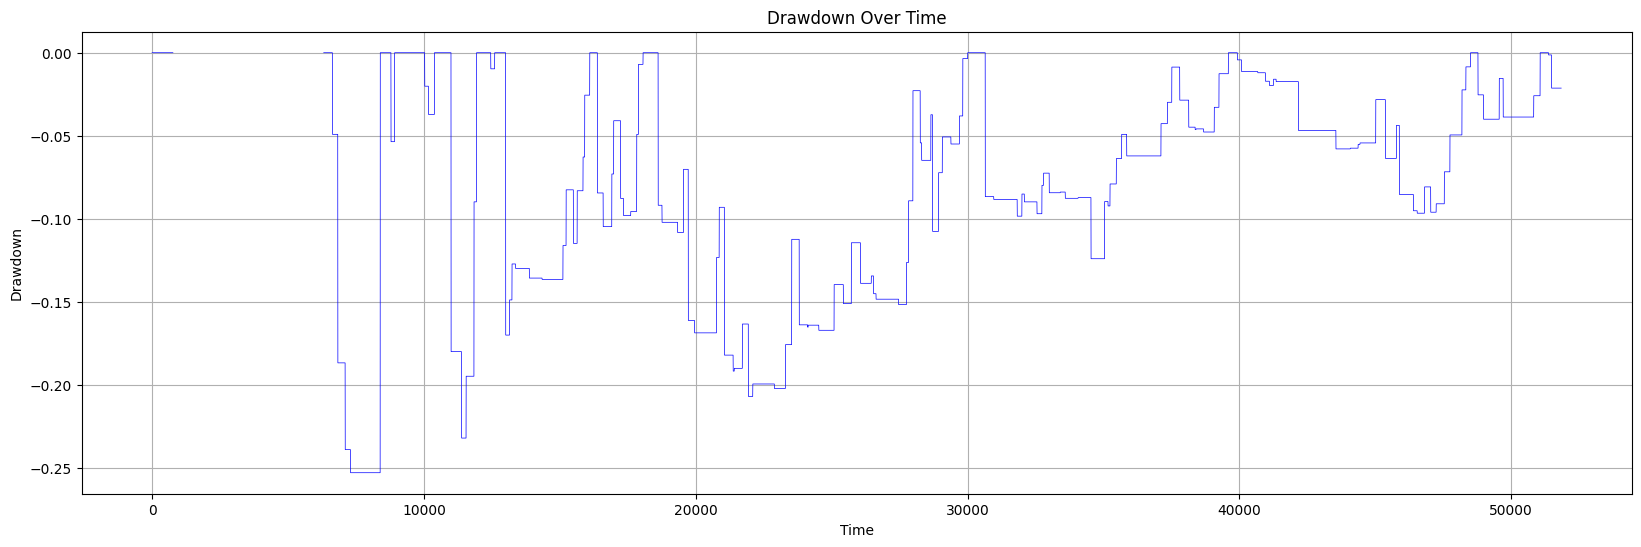

In [273]:
# Replace NaN values with 0
data_filled = drawdown.fillna(0)

# Plotting the data
plt.figure(figsize=(20, 6))
plt.plot(data_filled, color='blue', linewidth=0.5)
plt.title('Drawdown Over Time')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.grid(True)
plt.show()

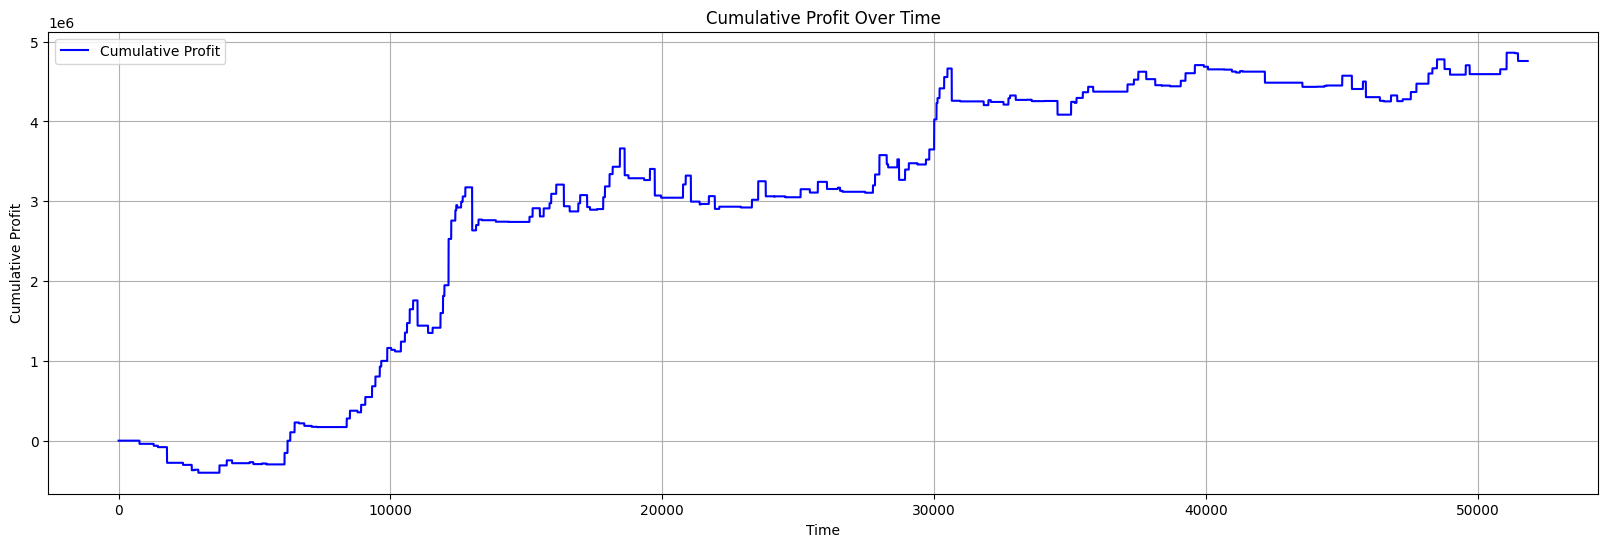

In [274]:
# Plotting the Cumulative Profit over time
plt.figure(figsize=(20, 6))
plt.plot(df_filtered['Cumulative Profit'], label='Cumulative Profit', color='blue')
plt.title('Cumulative Profit Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Profit')
plt.grid(True)
plt.legend()
plt.show()

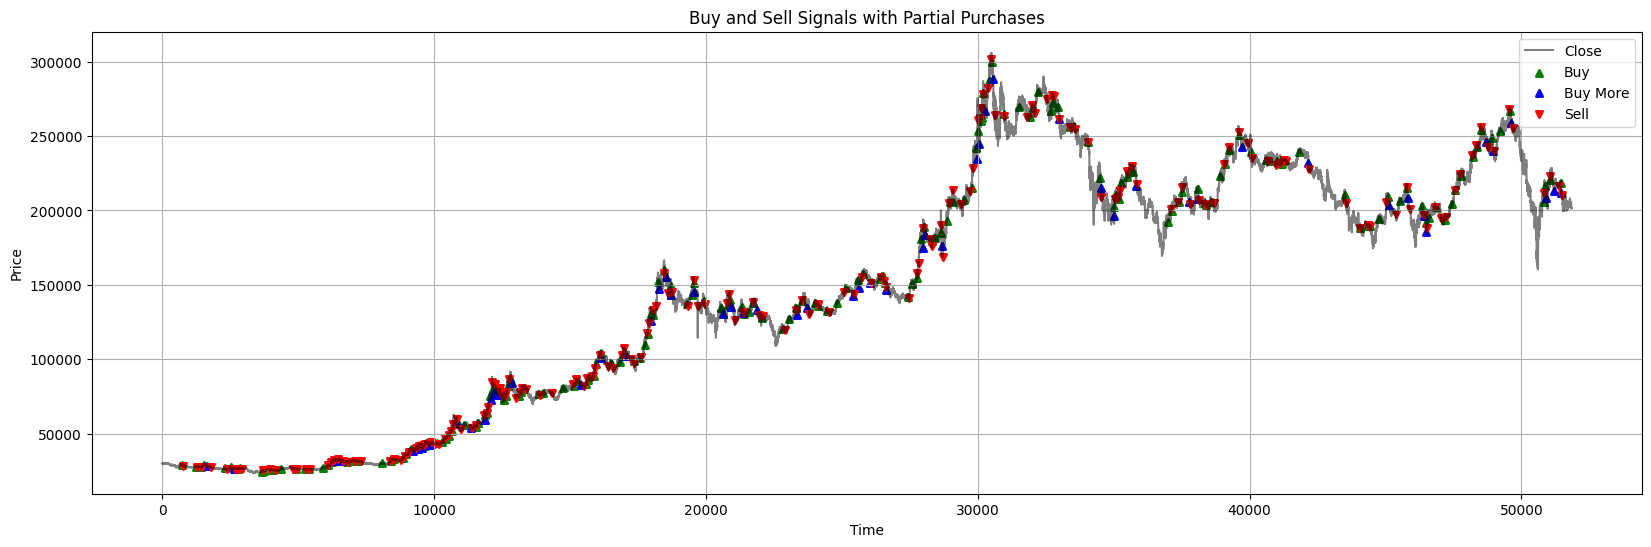

In [275]:
# 날짜를 인덱스로 설정
df_filtered['time'] = pd.to_datetime(df_filtered['time'])

# 분할 매수 (Buy)와 추가 매수 (Buy more), 매도 (Sell) 신호에 대한 인덱스 추출
buy_signals = df_filtered[df_filtered['Action'] == 'Buy']
buy_more_signals = df_filtered[df_filtered['Action'] == 'Buy more']
sell_signals = df_filtered[df_filtered['Action'] == 'Sell']

# 주식 가격과 신호를 시각화
plt.figure(figsize=(20, 6))
plt.tight_layout()
plt.plot(df_filtered.index, df_filtered['close'], label='Close', color='black', alpha=0.5)
plt.scatter(buy_signals.index, buy_signals['close'], label='Buy', marker='^', color='green', lw=2, s=20)
plt.scatter(buy_more_signals.index, buy_more_signals['close'], label='Buy More', marker='^', color='blue', lw=2, s=20)
plt.scatter(sell_signals.index, sell_signals['close'], label='Sell', marker='v', color='red', lw=2, s=20)

plt.title('Buy and Sell Signals with Partial Purchases')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

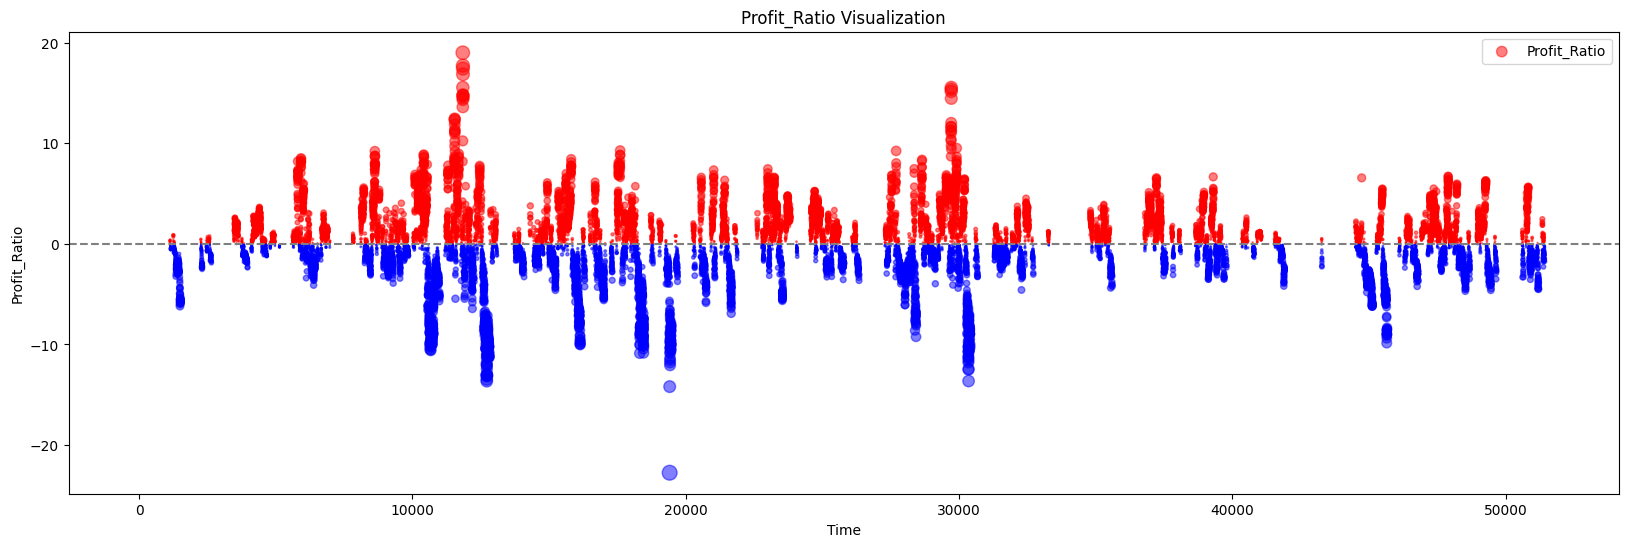

In [213]:
# 시각화
fig, ax = plt.subplots(figsize=(20, 6))

# Y축 0에 선 추가
ax.axhline(y=0, color='gray', linestyle='--')

# Profit_Ratio 값에 비례한 원 그리기
marker_size = 5 * abs(df_filtered['Profit_Ratio'])
colors = ['red' if x >= 0 else 'blue' for x in df_filtered['Profit_Ratio']]
ax.scatter(df_filtered.index, df_filtered['Profit_Ratio'], s=marker_size, alpha=0.5, color=colors, label='Profit_Ratio')

# 축 및 제목 설정
ax.set_xlabel('Time')
ax.set_ylabel('Profit_Ratio')
ax.set_title('Profit_Ratio Visualization')
ax.legend()

# 그래프 표시
plt.show()